In [3]:
%%time

import tensorflow as tf
print(tf.__version__)
import sys
sys.path.append("..")
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np


def plot_loss(history, *losses):
    for loss in losses:
        plt.plot(history.history[loss], label=loss)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def scaling(x, min, max):
    return np.where(x < min, 0.0, np.where(x > max, 1.0, (x - min) / (max - min)))

early_stopping = EarlyStopping(
    monitor='val_loss',  # 
    patience=50,        # 
    verbose=1,          # 
    mode='min',         # 
    restore_best_weights=True  # 
)


from keras.callbacks import Callback

class TerminateOnNegative(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        if loss is not None:
            if loss < -0.5:
                print('Negative loss detected and terminating training')
                self.model.stop_training = True

2024-03-01 14:31:47.712431: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-01 14:31:47.747648: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-01 14:31:47.747666: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-01 14:31:47.747687: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 14:31:47.754212: I tensorflow/core/platform/cpu_feature_g

2.14.0
CPU times: user 2.91 s, sys: 3.4 s, total: 6.32 s
Wall time: 2.29 s


In [4]:
SAVE_DIR = "../data"
file_criteo = SAVE_DIR + "/Alibaba-lift.csv"
df_criteo_ori = pd.read_csv(file_criteo, sep=',')

In [6]:
pd.set_option('display.max_columns', None)
df_criteo_ori.describe()

,sample_id,key1,key2,label,f0,f1,f2,f3,exposure,treatment,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15
count,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06,1.986106e+06
mean,3.362414e+15,-3.176048e+15,-1.342120e+17,1.520110e-02,3.416738e+18,-6.609984e+16,1.925756e+18,3.124932e+17,4.242296e-01,7.253978e-01,-3.509086e+18,-3.139012e+17,9.021360e+17,2.220550e+03,2.544287e+03,5.420219e+06,1.238046e+01,1.236924e+01,5.401186e+18,-2.499659e+17,4.668169e+06,5.139018e+06
std,5.322668e+18,5.322290e+18,4.260319e+18,1.223521e-01,1.856426e+18,4.639322e+18,2.103216e+18,1.048209e+18,4.942256e-01,4.463137e-01,3.697836e+18,3.279222e+18,9.934901e+17,2.600796e+03,3.044080e+03,2.968799e+06,6.239693e+00,6.266189e+00,6.664024e+16,2.838146e+18,3.421771e+06,2.596737e+06
min,-9.223354e+18,-9.223370e+18,-9.160239e+18,0.000000e+00,3.014035e+17,-8.889353e+18,-3.266576e+18,-1.703000e+18,0.000000e+00,0.000000e+00,-7.843689e+18,-7.446917e+18,0.000000e+00,0.000000e+00,0.000000e+00,1.203400e+04,0.000000e+00,0.000000e+00,5.397748e+18,-8.331471e+18,2.555960e+05,1.320180e+05
25%,-4.605181e+18,-4.608647e+18,-3.916990e+18,0.000000e+00,3.014035e+17,-5.701636e+18,7.467628e+17,6.029948e+17,0.000000e+00,0.000000e+00,-7.843689e+18,-1.703000e+18,6.029948e+17,0.000000e+00,0.000000e+00,2.534558e+06,1.500000e+01,1.500000e+01,5.397748e+18,7.467628e+17,7.759870e+05,2.991024e+06
50%,9.739464e+15,-5.810557e+15,-6.684478e+16,0.000000e+00,4.522981e+18,2.692163e+18,7.467628e+17,6.029948e+17,0.000000e+00,1.000000e+00,-1.616922e+18,6.029948e+17,6.029948e+17,1.529000e+03,1.236000e+03,5.913921e+06,1.500000e+01,1.500000e+01,5.397748e+18,7.467628e+17,4.322878e+06,5.431455e+06
75%,4.609306e+18,4.608307e+18,3.347696e+18,0.000000e+00,4.522981e+18,2.692163e+18,5.533572e+18,6.029948e+17,1.000000e+00,1.000000e+00,-1.616922e+18,2.462676e+18,6.029948e+17,4.283000e+03,4.031000e+03,7.599750e+06,1.500000e+01,1.500000e+01,5.397748e+18,7.467628e+17,7.642739e+06,6.681882e+06
max,9.223354e+18,9.223366e+18,9.207827e+18,1.000000e+00,4.522981e+18,7.846451e+18,5.533572e+18,5.533572e+18,1.000000e+00,1.000000e+00,2.593209e+18,5.117079e+18,5.533572e+18,9.410000e+03,9.933000e+03,9.976572e+06,3.000000e+01,3.000000e+01,6.692674e+18,7.467628e+17,9.832039e+06,9.892601e+06


In [7]:
value_counts = df_criteo_ori['treatment'].value_counts()

print(value_counts)

1    1440717
0     545389
Name: treatment, dtype: int64


In [8]:
%%time

sample = 0.15
random_state=20220720
df_criteo=df_criteo_ori.sample(frac=sample, random_state=random_state).reset_index(drop=True)



# X = df_criteo[['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11']].values

# X[:, 0] = scaling(X[:, 0], min=np.min(X[:, 0]), max=np.max(X[:, 0]))
# X[:, 1] = scaling(X[:, 1], min=np.min(X[:, 1]), max=np.max(X[:, 1]))
# X[:, 2] = scaling(X[:, 2], min=np.min(X[:, 2]), max=np.max(X[:, 2]))
# X[:, 3] = scaling(X[:, 3], min=np.min(X[:, 3]), max=np.max(X[:, 3]))
# X[:, 4] = scaling(X[:, 4], min=np.min(X[:, 4]), max=np.max(X[:, 4]))
# X[:, 5] = scaling(X[:, 5], min=np.min(X[:, 5]), max=np.max(X[:, 5]))
# X[:, 6] = scaling(X[:, 6], min=np.min(X[:, 6]), max=np.max(X[:, 6]))
# X[:, 7] = scaling(X[:, 7], min=np.min(X[:, 7]), max=np.max(X[:, 7]))
# X[:, 8] = scaling(X[:, 8], min=np.min(X[:, 8]), max=np.max(X[:, 8]))
# X[:, 9] = scaling(X[:, 9], min=np.min(X[:, 9]), max=np.max(X[:, 9]))
# X[:, 10] = scaling(X[:, 10], min=np.min(X[:, 10]), max=np.max(X[:, 10]))
# X[:, 11] = scaling(X[:, 11], min=np.min(X[:, 11]), max=np.max(X[:, 11]))
# # 
columns = [f'f{i}' for i in range(16)] 
X = df_criteo[columns].values
# 
for i in range(X.shape[1]):
    # 
    X[:, i] = scaling(X[:, i], min=np.min(X[:, i]), max=np.max(X[:, i]))

T = df_criteo['treatment'].values.reshape(-1, 1)
Y_visit = df_criteo['exposure'].values.reshape(-1, 1)
Y_conv = df_criteo['label'].values.reshape(-1, 1)

T.shape, Y_visit.shape, Y_conv.shape


# calculate len
train_len = int(len(X) * 0.70)
cali_len = int(len(X) * 0.05)
test_len = len(X) - train_len - cali_len

# obtain train set
X_train = X[:train_len, :]
T_train = T[:train_len, :]
Y_visit_train = Y_visit[:train_len, :]
Y_conv_train = Y_conv[:train_len, :]

# obtain calibration set
X_cali = X[train_len:train_len+cali_len, :]
T_cali = T[train_len:train_len+cali_len, :]
Y_visit_cali = Y_visit[train_len:train_len+cali_len, :]
Y_conv_cali = Y_conv[train_len:train_len+cali_len, :]

# obtain test set
X_test = X[train_len+cali_len:, :]
T_test = T[train_len+cali_len:, :]
Y_visit_test = Y_visit[train_len+cali_len:, :]
Y_conv_test = Y_conv[train_len+cali_len:, :]

print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

# make covariate shift
# condition_cali = (X_cali[:, 0] > 0.3) & (X_cali[:, 1] < 0.7)
# X_cali = X_cali[condition_cali]
# T_cali = T_cali[condition_cali]
# Y_visit_cali = Y_visit_cali[condition_cali]
# Y_conv_cali = Y_conv_cali[condition_cali]

# condition_test = (X_test[:, 0] > 0.3) & (X_test[:, 1] < 0.7)
# X_test = X_test[condition_test]
# T_test = T_test[condition_test]
# Y_visit_test = Y_visit_test[condition_test]
# Y_conv_test = Y_conv_test[condition_test]

# print(train_len, X_train.shape, X_test.shape, len(X), X_cali.shape)

208541 (208541, 16) (74480, 16) 297916 (14895, 16)
CPU times: user 130 ms, sys: 18.9 ms, total: 149 ms
Wall time: 147 ms


# First, on the train set:

### (i) Train DRP model

iteration =  1


2024-03-01 14:32:53.277598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 909 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:1b:00.0, compute capability: 8.9


Epoch 1/2000


2024-03-01 14:32:54.687264: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f93b131e7e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-01 14:32:54.687284: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-03-01 14:32:54.691412: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-01 14:32:54.718681: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-03-01 14:32:54.888662: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 2s 2s/step - loss: 0.4129 - obj: 0.4126 - val_loss: 0.4074 - val_obj: 0.4071
Epoch 2/2000
1/1 [==============================] - 0s 81ms/step - loss: 0.4077 - obj: 0.4074 - val_loss: 0.4022 - val_obj: 0.4019
Epoch 3/2000
1/1 [==============================] - 0s 101ms/step - loss: 0.4025 - obj: 0.4022 - val_loss: 0.3971 - val_obj: 0.3968
Epoch 4/2000
1/1 [==============================] - 0s 96ms/step - loss: 0.3974 - obj: 0.3971 - val_loss: 0.3921 - val_obj: 0.3917
Epoch 5/2000
1/1 [==============================] - 0s 89ms/step - loss: 0.3924 - obj: 0.3921 - val_loss: 0.3871 - val_obj: 0.3868
Epoch 6/2000
1/1 [==============================] - 0s 85ms/step - loss: 0.3875 - obj: 0.3872 - val_loss: 0.3821 - val_obj: 0.3818
Epoch 7/2000
1/1 [==============================] - 0s 87ms/step - loss: 0.3826 - obj: 0.3823 - val_loss: 0.3772 - val_obj: 0.3769
Epoch 8/2000
1/1 [==============================] - 0s 90ms/step - loss: 0.3777 - obj: 0.3774 - v

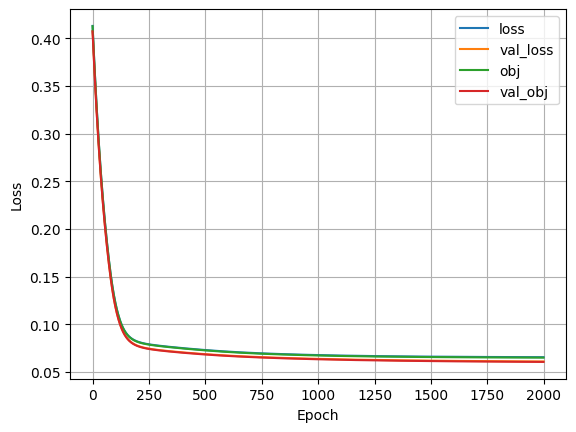

CPU times: user 6min 22s, sys: 2min 11s, total: 8min 34s
Wall time: 3min 21s


In [9]:
%%time
# DPR on train set
sys.path.append("..")
from model.uplift_model import *

count = 1
# 2.5e-5
import keras
import keras.backend as K
import tensorflow as tf
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from model.roi_model import *

# final_model = get_roi_rank_criteo_model()
# final_model.compile(loss=None, optimizer='adam')
#lambda y_true,y_pred: y_pred
# print('trainable_weights')
# for x in final_model.trainable_weights:
#     print(x.name)
# print('non_trainable_weights')
# for x in final_model.non_trainable_weights:
#     print(x.name)
# final_model.summary()

for i in range(count):

    print("iteration = ", i + 1)
    
    final_model = get_roi_rank_ali_model()
    final_model.compile(loss=None, optimizer='adam')

    mcp_save = ModelCheckpoint('../model_file/roi/criteo/final_model/roi_rank/roi_rank_criteo_model_{}_{}.h5'.format(i+1, sample), save_best_only=False, monitor='val_loss', mode='min', save_weights_only=True)
    history = final_model.fit([X_train, T_train, Y_conv_train, Y_visit_train], validation_split=0.2, epochs=2000, batch_size=2000000, shuffle=True, verbose=1, callbacks=[mcp_save,TerminateOnNegative()])
    plot_loss(history, "loss", "val_loss", "obj", "val_obj")

# Second, on the calibration set:

### (i) Infer DRP model to obtain $\hat{roi}$.

In [10]:
sample = 0.15

In [35]:

import sklearn 
import sklearn.metrics
from metric.Metric import *
sys.path.append("..")
from model.roi_model import *

count = 1

DRP_aucc_cali_list = []
roi_rank_pre_cali_list = []
for i in range(count):
    
    #print("iteration = ", i + 1)
    
    final_model = get_roi_rank_ali_model()
    final_model.load_weights('../model_file/roi/criteo/final_model/roi_rank/roi_rank_criteo_model_{}_{}.h5'.format(i+1, sample))

    #print("cali")
    roi_rank_pre_cali = final_model.predict([X_cali, T_cali, Y_conv_cali, Y_visit_cali])
    DRP_aucc = get_uplift_model_aucc_no_show(t=(T_cali > 0.5).flatten(), y_reward=Y_conv_cali.flatten(), y_cost=Y_visit_cali.flatten(), roi_pred=roi_rank_pre_cali.flatten(), quantile=200)
    roi_rank_pre_cali_list.append(roi_rank_pre_cali)
    DRP_aucc_cali_list.append(DRP_aucc)
    
    print("\n")
    

466/466 [==============================] - 1s 2ms/step
AUCC =  0.7559738188060005


### (ii) Calculate $roi^*$ by Algorithm 2.

In [36]:
import numpy as np
from scipy.misc import derivative
from scipy.special import expit as sigmoid
from scipy.special import logit

def func(ti, yr, yc, si):
    qi = sigmoid(si)
    if ti == 1:
        return - yr*np.log(qi/(1-qi)) - yc*np.log(1-qi)
    else:
        return yr*np.log(qi/(1-qi)) + yc*np.log(1-qi)

    
def derivative_values(ti, yr, yc, si):
    def func_fixed_y(si_val):
        return func(ti, yr, yc, si_val)
    deriv = derivative(func_fixed_y, si, dx=1e-6)
    return deriv


def bst(ti, yr, yc):
    epsilon = 1e-5
    # corner case
    if yr == 0:
        return epsilon
    elif yc == 0:
        return 1 - epsilon
    
    roi_l = 0.0
    roi_r = 1.0
    roi_star = (roi_l + roi_r) / 2
    

    while np.abs(roi_r - roi_l) > epsilon:
        derivatives_at_si = derivative_values(ti, yr, yc, logit(roi_star))
        if np.abs(derivatives_at_si) < epsilon:
            break
        if derivatives_at_si > 0:
            roi_r = roi_star
        else:
            roi_l = roi_star
        roi_star = (roi_l + roi_r) / 2
    return roi_star


results = np.zeros(T_cali.shape)

# iterate
for i in range(T_cali.shape[0]):
    # call bst
    results[i] = bst(T_cali[i], Y_conv_cali[i], Y_visit_cali[i])

/tmp/ipykernel_7221/1185985485.py:17: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  deriv = derivative(func_fixed_y, si, dx=1e-6)


In [37]:
delta_roi = np.abs(results - roi_rank_pre_cali)

In [38]:
np.unique(delta_roi)

array([8.92692876e-05, 1.20269371e-04, 1.28947536e-04, ...,
       9.97556599e-01, 9.98152670e-01, 9.98671690e-01])

### (iii) Infer DRP's MC Dropout model to obtain $\hat{r}(x)$.

In [22]:
%%time
import sklearn 
import sklearn.metrics
from metric.Metric import *
from concurrent.futures import ProcessPoolExecutor

DRP_aucc_cali_mc_list = []

for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_roi_rank_ali_model_with_dropout()
    final_model.load_weights('../model_file/roi/criteo/final_model/roi_rank/roi_rank_criteo_model_{}_{}.h5'.format(i+1, sample))

    # multiple prediction
    n_iterations = 10
    all_predictions_cali = []
    
    for j in range(n_iterations):
        print(j)
        
        print("cali")
        predictions = final_model.predict([X_cali, T_cali, Y_conv_cali, Y_visit_cali])
        all_predictions_cali.append(predictions)
        DRP_aucc = get_uplift_model_aucc_no_show(t=(T_cali > 0.5).flatten(), y_reward=Y_conv_cali.flatten(), y_cost=Y_visit_cali.flatten(), roi_pred=predictions.flatten(), quantile=200)
        DRP_aucc_cali_list.append(DRP_aucc[0])
    
    print("\n")
    
# obtain mean and std
mean_pred = np.mean(all_predictions_cali, axis=0)
std_pred = np.std(all_predictions_cali, axis=0)


iteration =  1
0
cali
466/466 [==============================] - 1s 2ms/step
AUCC =  0.7385570168056395
1
cali
466/466 [==============================] - 1s 2ms/step
AUCC =  0.7546317179721628
2
cali
466/466 [==============================] - 1s 2ms/step
AUCC =  0.7621051099273518
3
cali
466/466 [==============================] - 1s 2ms/step
AUCC =  0.75025494290207
4
cali
466/466 [==============================] - 1s 2ms/step
AUCC =  0.766935939018713
5
cali
466/466 [==============================] - 1s 2ms/step
AUCC =  0.7709998013589473
6
cali
466/466 [==============================] - 1s 2ms/step
AUCC =  0.7714616797148058
7
cali
466/466 [==============================] - 1s 2ms/step
AUCC =  0.7497746258042308
8
cali
466/466 [==============================] - 1s 2ms/step
AUCC =  0.765785761833927
9
cali
466/466 [==============================] - 1s 3ms/step
AUCC =  0.7692988880650086


CPU times: user 19.4 s, sys: 1.47 s, total: 20.9 s
Wall time: 13.7 s


### (iv) Calculate $\hat{q}$ by Algorithm 3

In [39]:
# Get scores
cal_scores = delta_roi/(std_pred + 1e-5)
n = len(cal_scores)

# set the error rate
alpha = 0.10
# Get the score quantile
qhat = np.quantile(cal_scores, np.ceil((n+1)*(1-alpha))/n, interpolation='higher')

### (v) Select $\widetilde{roi}$'s equation form from 5a to 5c.

In [40]:
# For mc only


ROI_1 = (1.476*roi_rank_pre_cali + std_pred) # AUCC 
ROI_2 = roi_rank_pre_cali/(std_pred + 1e5)
ROI_3 = 0.976*roi_rank_pre_cali + std_pred
DRP_aucc_cali = get_uplift_model_aucc_no_show(t=(T_cali > 0.5).flatten(), y_reward=Y_conv_cali.flatten(), y_cost=Y_visit_cali.flatten(), roi_pred=ROI_1.flatten(), quantile=200)

AUCC =  0.7689387867125814


In [41]:
ROI_1 = roi_rank_pre_cali*(110.45*roi_rank_pre_cali + qhat*std_pred) # AUCC 
ROI_2 = roi_rank_pre_cali/(qhat*std_pred + 1e5)
ROI_3 = (117.45*roi_rank_pre_cali + qhat*std_pred) #
DRP_aucc_cali = get_uplift_model_aucc_no_show(t=(T_cali > 0.5).flatten(), y_reward=Y_conv_cali.flatten(), y_cost=Y_visit_cali.flatten(), roi_pred=ROI_1.flatten(), quantile=200)

AUCC =  0.7846865034777347


# Third, on the test set:

### (i) Infer DRP model to obtain $\hat{roi}$.

In [31]:
import sklearn 
import sklearn.metrics
from metric.Metric import *

count = 1

DRP_aucc_test_list = []
roi_rank_pre_test_list = []
for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_roi_rank_ali_model()
    final_model.load_weights('../model_file/roi/criteo/final_model/roi_rank/roi_rank_criteo_model_{}_{}.h5'.format(i+1, sample))

    roi_rank_pre_test = final_model.predict([X_test, T_test, Y_conv_test, Y_visit_test])
    roi_rank_pre_test_list.append(roi_rank_pre_test)
    DRP_aucc = get_uplift_model_aucc_no_show(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=roi_rank_pre_test.flatten(), quantile=200)
    DRP_aucc_test_list.append(DRP_aucc)
    
    print("\n")


iteration =  1
2328/2328 [==============================] - 5s 2ms/step
AUCC =  0.7121776868169362


In [32]:

import pandas as pd

def get_aucc_cost_curve(aucc_list):
    delta_cost_list_group = np.array([aucc[1] for aucc in aucc_list])
    delta_reward_list_group = np.array([aucc[2] for aucc in aucc_list])
    
    avg_delta_cost_list = np.mean(delta_cost_list_group, axis=0)
    avg_delta_reward_list = np.mean(delta_reward_list_group, axis=0)
    
    df_aucc_cost_curve = pd.DataFrame(avg_delta_cost_list, columns=['delta_cost'])
    df_aucc_cost_curve['delta_reward'] = avg_delta_reward_list
    
    return df_aucc_cost_curve

DRP_avg_aucc_cost_curve = get_aucc_cost_curve(DRP_aucc_test_list)
print("aucc = ", np.sum(DRP_avg_aucc_cost_curve['delta_reward'].values) / (DRP_avg_aucc_cost_curve['delta_reward'].values[-1] * 201))
DRP_avg_aucc_cost_curve.to_csv("../figure/mt/b_DRP_avg_aucc_cost_curve_1.0.csv")


aucc =  0.7121776868169362


### (ii) Infer DRP's MC Dropout to obtain $\hat{r}(x)$.

In [12]:
%%time
import time
import sklearn 
import sklearn.metrics
from metric.Metric import *
from concurrent.futures import ProcessPoolExecutor
sys.path.append("..")
from model.uplift_model import *
from model.roi_model import *


count = 1
sample = 1.0

DRP_aucc_test_mc_list = []

for i in range(count):
    
    print("iteration = ", i + 1)
    
    final_model = get_roi_rank_ali_model_with_dropout()
    final_model.load_weights('../model_file/roi/criteo/final_model/roi_rank/roi_rank_criteo_model_{}_{}.h5'.format(i+1, sample))

    # multiple prediction
    n_iterations = 10
    all_predictions_test = []
    
    for j in range(n_iterations):
        print(j)
        
        print("test")
        predictions = final_model.predict([X_test, T_test, Y_conv_test, Y_visit_test])
        all_predictions_test.append(predictions)
        DRP_aucc_mc = get_uplift_model_aucc_no_show(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=predictions.flatten(), quantile=200)
        DRP_aucc_test_mc_list.append(DRP_aucc_mc[0])
    
    print("\n")
    
# cal std and mean
mean_pred_test = np.mean(all_predictions_test, axis=0)
std_pred_test = np.std(all_predictions_test, axis=0)

end_time = time.time()
print(end_time)

iteration =  1
0
test
2328/2328 [==============================] - 6s 2ms/step
AUCC =  0.7291885793037205
1
test
2328/2328 [==============================] - 6s 3ms/step
AUCC =  0.7161431089413126
2
test
2328/2328 [==============================] - 5s 2ms/step
AUCC =  0.7264878888734091
3
test
2328/2328 [==============================] - 6s 2ms/step
AUCC =  0.7180412367634184
4
test
2328/2328 [==============================] - 5s 2ms/step
AUCC =  0.7186120215565097
5
test
2328/2328 [==============================] - 6s 2ms/step
AUCC =  0.7181299435076919
6
test
2328/2328 [==============================] - 6s 2ms/step
AUCC =  0.7197850804383864
7
test
2328/2328 [==============================] - 6s 2ms/step
AUCC =  0.7242876944951742
8
test
2328/2328 [==============================] - 6s 2ms/step
AUCC =  0.7250775827506698
9
test
2328/2328 [==============================] - 5s 2ms/step
AUCC =  0.7146356483896085


1709277116.8542252
CPU times: user 1min 28s, sys: 5.13 s, total: 1min 33s

### (iii) With $\hat{q}$  and the selected expression, $\widetilde{roi}(x_{test})$ is obtained.

In [29]:
# # calculate DRP-MC aucc
rDRP_aucc_test_list = []
ROI_1 = (1.476*roi_rank_pre_test + std_pred_test) # 
rDRP_aucc = get_uplift_model_aucc_no_show(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=ROI_1.flatten(), quantile=200)
rDRP_aucc_test_list.append(rDRP_aucc)

# save DRP-MC AUCC result

rDRP_avg_aucc_cost_curve = get_aucc_cost_curve(rDRP_aucc_test_list)
print("aucc = ", np.sum(rDRP_avg_aucc_cost_curve['delta_reward'].values) / (rDRP_avg_aucc_cost_curve['delta_reward'].values[-1] * 201))
rDRP_avg_aucc_cost_curve.to_csv("../figure/ali/b_DRP_MC_avg_aucc_cost_curve_1.0.csv")


AUCC =  0.7166743122505457
aucc =  0.7166743122505457


In [42]:
# calculate rDRP aucc
rDRP_aucc_test_list = []
ROI_1 = roi_rank_pre_test*(110.45*roi_rank_pre_test + qhat*std_pred_test)# 
rDRP_aucc = get_uplift_model_aucc_no_show(t=(T_test > 0.5).flatten(), y_reward=Y_conv_test.flatten(), y_cost=Y_visit_test.flatten(), roi_pred=ROI_1.flatten(), quantile=200)
rDRP_aucc_test_list.append(rDRP_aucc)

# save rDRP AUCC result

rDRP_avg_aucc_cost_curve = get_aucc_cost_curve(rDRP_aucc_test_list)
print("aucc = ", np.sum(rDRP_avg_aucc_cost_curve['delta_reward'].values) / (rDRP_avg_aucc_cost_curve['delta_reward'].values[-1] * 201))
rDRP_avg_aucc_cost_curve.to_csv("../figure/ali/b_rDRP_avg_aucc_cost_curve_1.0.csv")


AUCC =  0.7214840621201456
aucc =  0.7214840621201456
